In [2]:
#data are from kaggle https://www.kaggle.com/datasets/portiamurray/anomaly-detection-smart-meter-data-sample 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn import preprocessing
import seaborn as sns

In [3]:
path = './Lastgang Elektroverbruche 160101-170511.xlsx'
df = pd.read_excel(path, engine='openpyxl', index_col=0)
df.isnull().sum()

Messung Gebäude 2ewz [kWh]    0
dtype: int64

In [4]:
df.index.name ='datetime'
df.columns = ['kwh']
df['date'] = df.index.date
df['time'] = df.index.time
df['year'] = df.index.year
df['weekday'] = df.index.strftime("%A")
df.head()

,kwh,date,time,year,weekday
datetime,,,,,
2016-01-01 00:15:00,2.85,2016-01-01,00:15:00,2016,Friday
2016-01-01 00:30:00,2.85,2016-01-01,00:30:00,2016,Friday
2016-01-01 00:45:00,3.00,2016-01-01,00:45:00,2016,Friday
2016-01-01 01:00:00,2.94,2016-01-01,01:00:00,2016,Friday
2016-01-01 01:15:00,2.79,2016-01-01,01:15:00,2016,Friday


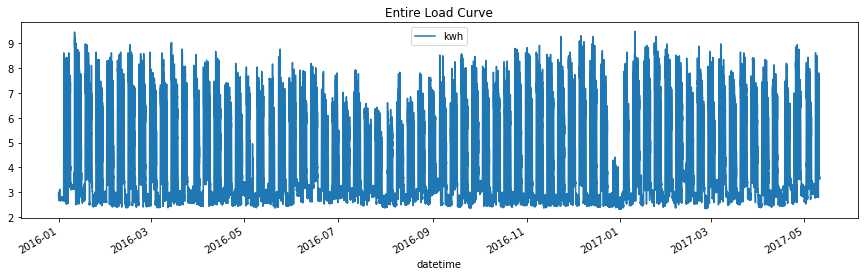

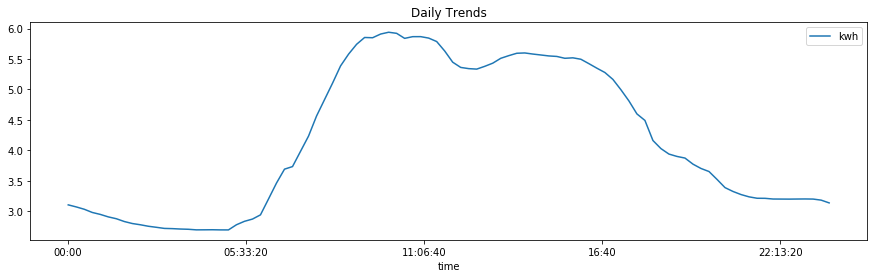

In [5]:
#Entire load curve and the daily load trends
pivot_kwh = df.pivot_table(index=df.index, 
                     values='kwh').plot(figsize=(15,4),
                     title='Entire Load Curve')
pivot_kwh_daily = df.pivot_table(index=df['time'], 
                     values='kwh',
                     aggfunc=np.mean).plot(figsize=(15,4),
                     title='Daily Trends')

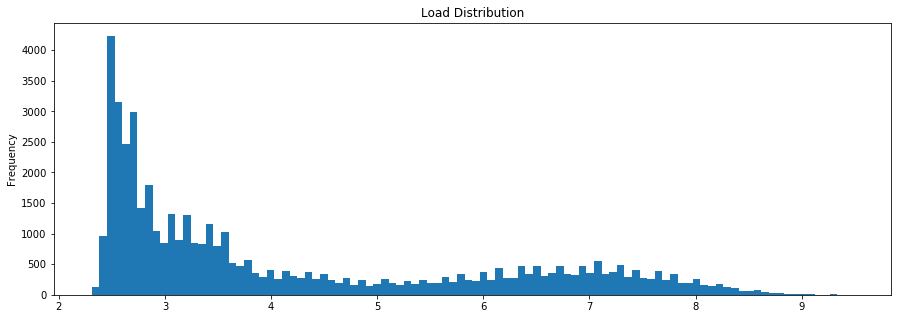

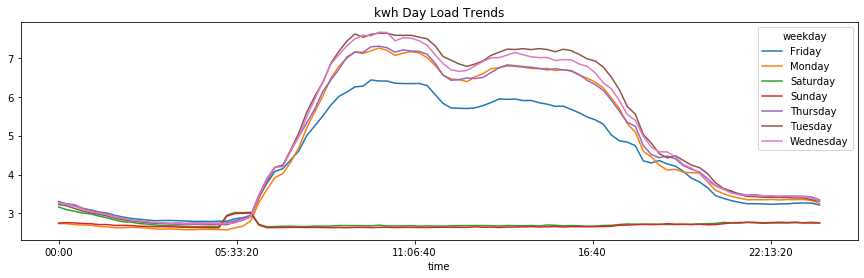

In [6]:
#Load distributions & daily load curve
dist_kwh = df['kwh'].plot.hist(figsize=(15, 5), bins=100, title='Load Distribution')

dist_kwh_weekday = df.pivot_table(index=df['time'], 
                     columns='weekday', 
                     values='kwh',
                     aggfunc=np.mean).plot(figsize=(15,4),
                     title='kwh Day Load Trends')

In [7]:
#normalize the energy data
def normalize_data(df):
    scaler = sklearn.preprocessing.MinMaxScaler()
    df['kwh']=scaler.fit_transform(df['kwh'].values.reshape(-1,1))
    return df

df_norm = normalize_data(df)
df_norm = df_norm.drop(columns=['date','time','year','weekday'])
df_norm.shape

(47581, 1)

In [8]:
df_norm.head()

,kwh
datetime,
2016-01-01 00:15:00,0.075314
2016-01-01 00:30:00,0.075314
2016-01-01 00:45:00,0.096234
2016-01-01 01:00:00,0.087866
2016-01-01 01:15:00,0.066946


In [9]:
#data_loading
def load_data(stock, seq_len):
    X_train = []
    y_train = []
    for i in range(seq_len, len(stock)):
        X_train.append(stock.iloc[i-seq_len : i, 0])
        y_train.append(stock.iloc[i, 0])
    
    X_test = X_train[40000:]             
    y_test = y_train[40000:]
    
    X_train = X_train[:40000]           
    y_train = y_train[:40000]
    
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    
    #4 reshape data to input into RNN models
    X_train = np.reshape(X_train, (40000, seq_len, 1))
    X_test = np.reshape(X_test, (X_test.shape[0], seq_len, 1))
    
    return [X_train, y_train, X_test, y_test]

In [10]:
seq_len = 20

X_train, y_train, X_test, y_test = load_data(df_norm, seq_len)

print('X_train.shape = ',X_train.shape)
print('y_train.shape = ', y_train.shape)
print('X_test.shape = ', X_test.shape)
print('y_test.shape = ',y_test.shape)

X_train.shape =  (40000, 20, 1)
y_train.shape =  (40000,)
X_test.shape =  (7561, 20, 1)
y_test.shape =  (7561,)


In [13]:
from keras.layers import Dense,Dropout,SimpleRNN,LSTM,Activation
from keras.models import Sequential
from sklearn.metrics import r2_score
import time #helper libraries
from keras.models import model_from_json
import sys

rnn_model = Sequential()

rnn_model.add(SimpleRNN(40,activation="relu",return_sequences=True, input_shape=(X_train.shape[1],1)))
rnn_model.add(Dropout(0.15))

rnn_model.add(SimpleRNN(40,activation="relu",return_sequences=True))
rnn_model.add(Dropout(0.15))

rnn_model.add(SimpleRNN(40,activation="relu",return_sequences=False))
rnn_model.add(Dropout(0.15))

rnn_model.add(Dense(1))

rnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_6 (SimpleRNN)    (None, 20, 40)            1680      
                                                                 
 dropout_6 (Dropout)         (None, 20, 40)            0         
                                                                 
 simple_rnn_7 (SimpleRNN)    (None, 20, 40)            3240      
                                                                 
 dropout_7 (Dropout)         (None, 20, 40)            0         
                                                                 
 simple_rnn_8 (SimpleRNN)    (None, 40)                3240      
                                                                 
 dropout_8 (Dropout)         (None, 40)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                

In [16]:
start = time.time()
rnn_model.compile(optimizer="adam",loss="MSE")
print('compilation time : {}'.format(time.time() - start))

compilation time : 0.3451352119445801


In [22]:
rnn_model.fit(X_train, y_train, epochs=10, batch_size=10000)

Epoch 1/10
4/4 [==============================] - 8s 2s/step - loss: 0.0041
Epoch 2/10
4/4 [==============================] - 8s 2s/step - loss: 0.0040
Epoch 3/10
4/4 [==============================] - 8s 2s/step - loss: 0.0039
Epoch 4/10
4/4 [==============================] - 9s 2s/step - loss: 0.0039
Epoch 5/10
4/4 [==============================] - 14s 4s/step - loss: 0.0038
Epoch 6/10
4/4 [==============================] - 12s 3s/step - loss: 0.0038
Epoch 7/10
4/4 [==============================] - 11s 3s/step - loss: 0.0037
Epoch 8/10
4/4 [==============================] - 10s 3s/step - loss: 0.0037
Epoch 9/10
4/4 [==============================] - 10s 2s/step - loss: 0.0036
Epoch 10/10
4/4 [==============================] - 9s 2s/step - loss: 0.0035


In [23]:
rnn_predictions = rnn_model.predict(X_test)

rnn_score = r2_score(y_test,rnn_predictions)
print("R2 Score of RNN model = ",rnn_score)

2022-05-01 19:33:04.845412: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


R2 Score of RNN model =  0.9675208314098391


In [24]:
lstm_model = Sequential()

lstm_model.add(LSTM(40,activation="relu",return_sequences=True, input_shape=(X_train.shape[1],1)))
lstm_model.add(Dropout(0.15))

lstm_model.add(LSTM(64,activation="relu",return_sequences=True))
lstm_model.add(Dropout(0.15))

lstm_model.add(LSTM(32,activation="relu",return_sequences=False))
lstm_model.add(Dropout(0.15))

lstm_model.add(Dense(1))

lstm_model.summary()

start = time.time()
lstm_model.compile(loss='mse', optimizer='adam')
print('compilation time : {}'.format(time.time() - start))

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 20, 40)            6720      
                                                                 
 dropout_12 (Dropout)        (None, 20, 40)            0         
                                                                 
 lstm_4 (LSTM)               (None, 20, 64)            26880     
                                                                 
 dropout_13 (Dropout)        (None, 20, 64)            0         
                                                                 
 lstm_5 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_14 (Dropout)        (None, 32)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                

In [25]:
start = time.time()
lstm_model.compile(loss='mse', optimizer='adam')
print('compilation time : {}'.format(time.time() - start))

compilation time : 0.04410910606384277


In [27]:
lstm_model.fit(X_train, y_train, epochs=10, batch_size=10000)

Epoch 1/10


2022-05-01 19:34:23.742919: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 18s 4s/step - loss: 0.1209
Epoch 2/10
4/4 [==============================] - 16s 4s/step - loss: 0.0926
Epoch 3/10
4/4 [==============================] - 16s 4s/step - loss: 0.0587
Epoch 4/10
4/4 [==============================] - 18s 5s/step - loss: 0.0451
Epoch 5/10
4/4 [==============================] - 17s 4s/step - loss: 0.0408
Epoch 6/10
4/4 [==============================] - 16s 4s/step - loss: 0.0344
Epoch 7/10
4/4 [==============================] - 16s 4s/step - loss: 0.0325
Epoch 8/10
4/4 [==============================] - 16s 4s/step - loss: 0.0280
Epoch 9/10
4/4 [==============================] - 15s 4s/step - loss: 0.0269
Epoch 10/10
4/4 [==============================] - 29s 8s/step - loss: 0.0251


In [31]:
lstm_predictions = lstm_model.predict(X_test)
lstm_score = r2_score(y_test,lstm_predictions)
print("R2 Score of LSTM model = ",lstm_score)

2022-05-01 19:39:14.356221: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


R2 Score of LSTM model =  0.6222642765442542


In [32]:
def plot_predictions(test, predicted, title):
    plt.figure(figsize=(16,4))
    plt.plot(test, color='blue',label='Actual power consumption data')
    plt.plot(predicted, alpha=0.7, color='orange',label='Predicted power consumption data')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Normalized power consumption scale')
    plt.legend()
    plt.show()
#ploting

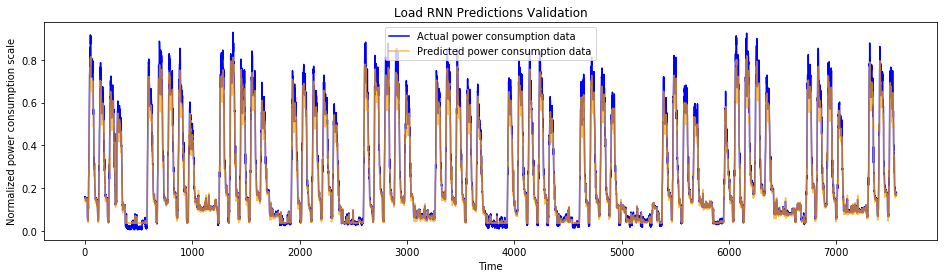

In [33]:
plot_predictions(y_test, rnn_predictions, "Load RNN Predictions Validation")



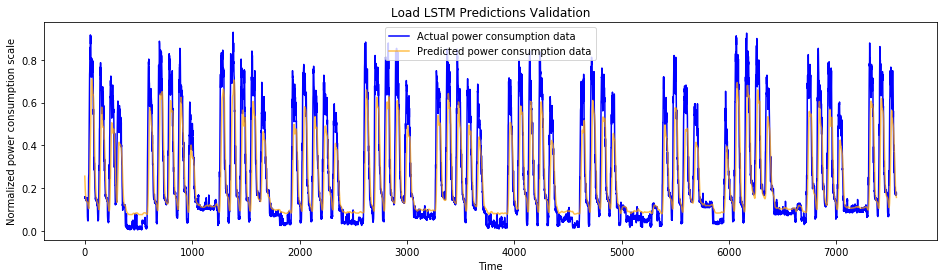

In [34]:
plot_predictions(y_test, lstm_predictions, "Load LSTM Predictions Validation")



In [38]:
# create the list of difference between prediction and test data
loaded_model = rnn_model
diff=[]
ratio=[]
p = loaded_model.predict(X_test)
# predictions = lstm.predict_sequences_multiple(loaded_model, x_test, 50, 50)
for u in range(len(y_test)):
    pr = p[u][0]
    ratio.append((y_test[u]/pr)-1)
    diff.append(abs(y_test[u]- pr))

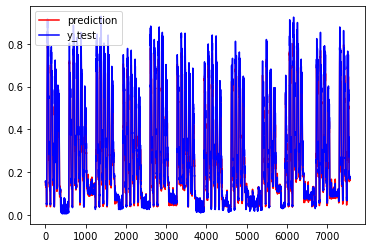

In [39]:
# plot the prediction and the reality (for the test data)
fig, axs = plt.subplots()
axs.plot(p,color='red', label='prediction')
axs.plot(y_test,color='blue', label='y_test')
plt.legend(loc='upper left')
plt.show()

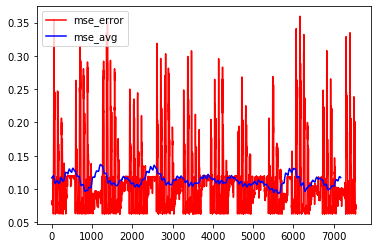

In [41]:
mse = []
mse = (np.square(p - y_test)).mean(axis=1)

mse_avg = np.convolve(mse, np.ones(96*4)/(96*4), mode='valid')
mse_avg_mean = np.mean(mse_avg)

fig, ax1 = plt.subplots()
ax1.plot(mse,color='red', label='mse_error')
ax1.plot(mse_avg,color='blue', label='mse_avg')

plt.legend(loc='upper left')
plt.show()

In [49]:
correction = 0.78
threshold = np.mean(mse_avg)*correction
anomaly = []
for x in mse_avg:
    if x <= threshold:
        anomaly.append(1)
    elif x >threshold:
        anomaly.append(0)
# test = (mse_avg<threshold).astype(int)

df['anomaly_rnn'] = 0
df['anomaly_rnn'][-(len(anomaly)):] = anomaly
df['anomaly_rnn'].value_counts()

/var/folders/dz/_wrf45ls4pv058mvwtk4m17w0000gn/T/ipykernel_14513/1995693289.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['anomaly_rnn'][-(len(anomaly)):] = anomaly


0    47581
Name: anomaly_rnn, dtype: int64

In [50]:
df['time_epoch'] = (df.index.astype(np.int64)/100000000000).astype(np.int64)

/Users/danielkent/miniforge3/envs/cv/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/danielkent/miniforge3/envs/cv/lib/python3.9/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/danielkent/miniforge3/envs/cv/lib/python3.9/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


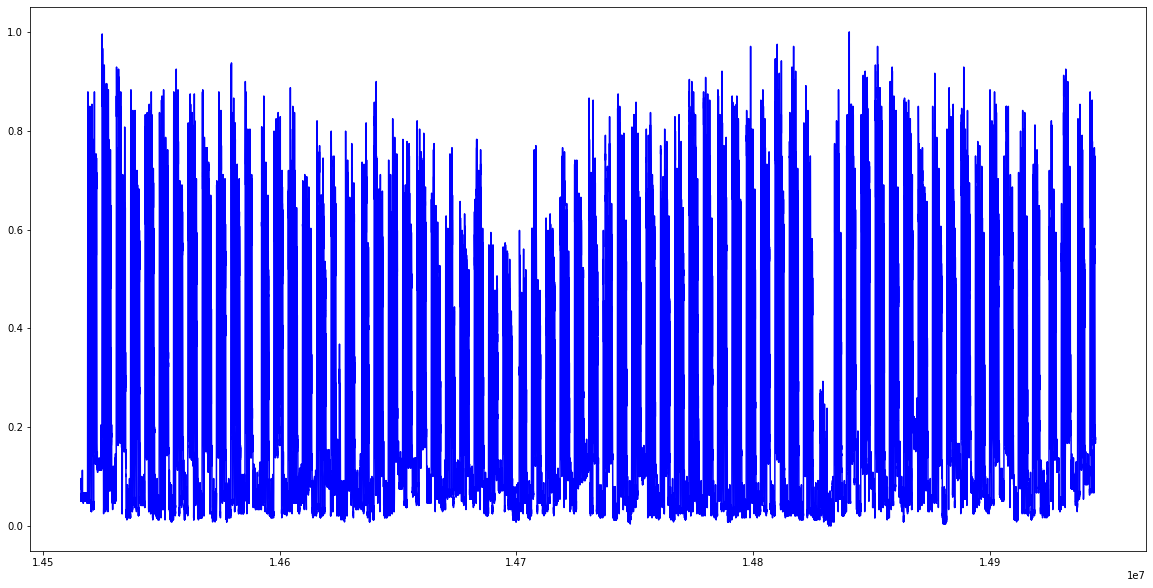

In [51]:
# visualisation of anomaly throughout time (viz 1)
fig, ax = plt.subplots()

a = df.loc[df['anomaly_rnn'] == 1, ['time_epoch', 'kwh']] #anomaly

ax.plot(df['time_epoch'], df['kwh'], color='blue')
ax.scatter(a['time_epoch'],a['kwh'], color='red')
fig.set_figheight(10)
fig.set_figwidth(20)
plt.show()

In [36]:
# create the list of difference between prediction and test data
loaded_model = lstm_model
diff=[]
ratio=[]
p = loaded_model.predict(X_test)
# predictions = lstm.predict_sequences_multiple(loaded_model, x_test, 50, 50)
for u in range(len(y_test)):
    pr = p[u][0]
    ratio.append((y_test[u]/pr)-1)
    diff.append(abs(y_test[u]- pr))

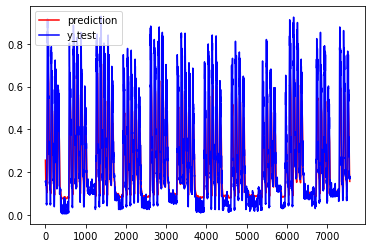

In [37]:
# plot the prediction and the reality (for the test data)
fig, axs = plt.subplots()
axs.plot(p,color='red', label='prediction')
axs.plot(y_test,color='blue', label='y_test')
plt.legend(loc='upper left')
plt.show()

Monte Carlo classification of single measurements


In [59]:
import collections as cl
df['freq'] = 0
appr = cl.defaultdict(float)
count = 0
alert_threshold = 0.001
reset_time = -1

for index, row in df.iterrows():
    val = row['kwh']
    if pd.isna(val):
        #print('Missing value at ', index)
        df.loc[index,'freq']= -1
    else:
        count += 1
        if val in appr:
            appr[val] += 1
        else:
            appr[val] = 1
        df.loc[index,'freq'] = appr[val]/count
            
    if count == reset_time:
        appr = cl.defaultdict(float)
        count = 0

/Users/danielkent/miniforge3/envs/cv/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/danielkent/miniforge3/envs/cv/lib/python3.9/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/danielkent/miniforge3/envs/cv/lib/python3.9/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/var/folders/dz/_wrf45ls4pv058mvwtk4m17w0000gn/T/ipykernel_14513/1026180313.py:12: UserWarning: Matplotli

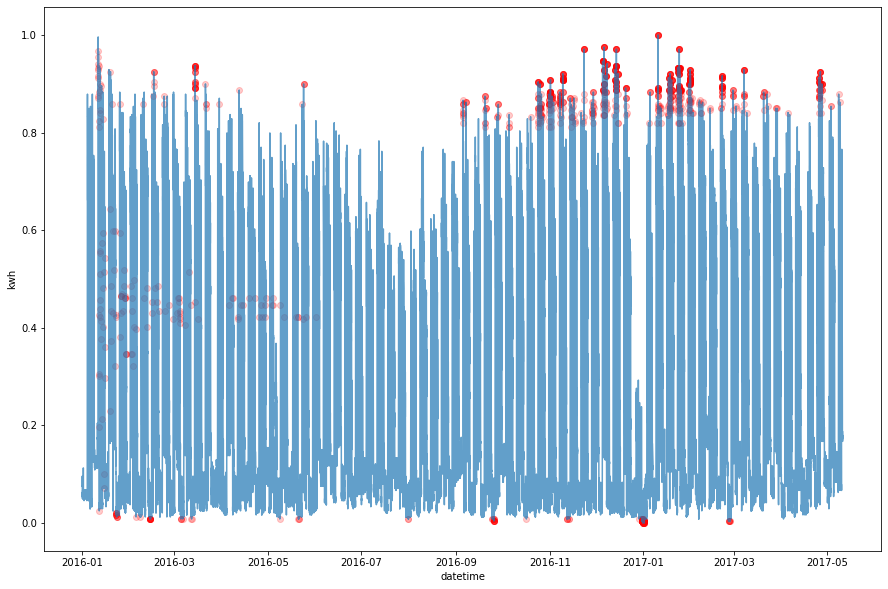

In [61]:
plotdf = df.reset_index()

anomaly_threshold = 0.001
plt.rcParams['figure.figsize'] = [15, 10] # plot size width and height
fig, ax = plt.subplots()
ax.set_xlabel('datetime')
ax.set_ylabel('kwh')
ax.plot(plotdf['datetime'], plotdf['kwh'], alpha = 0.7)

for step in range(3):
    ax.scatter(plotdf.loc[plotdf['freq'] < anomaly_threshold/(step+1)]['datetime'], plotdf.loc[plotdf['freq'] <anomaly_threshold/(step+1)]['kwh'], color='red', alpha = 0.2 * (step+1))
fig.show()